<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/14_cnn_image/deli_proj_pract_15_cnn_image_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b> **Я.Практикум. Проект №14** </b></font>
    
<font size=6><b> **Определение возраста покупателей** </b></font>

***

# Постановка задачи

**Заказчик**  
Сетевой супермаркет «Хлеб-Соль»

**Цель**  
Построить модель для использования в системе обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  

Качество модели следует оценивать при помощи MAE, значение которого на тестовой выборке должно быть не больше 8.

**Задачи**  

1. Провести исследовательский анализ набора фотографий.
1. Подготовить данные к обучению.
1. Обучить нейронную сеть и рассчитать её качество.

**Исходные данные**  
Набор фотографий людей с указанием возраста, основанный на датасете, представленном в работе:  
**E Agustsson, R Timofte, S Escalera, X Baro, I Guyon, R Rothe** Apparent and real age estimation in still images with deep residual regressors on APPA-REAL database // 12th IEEE International Conference and Workshops on Automatic Face and Gesture Recognition (FG). - 2017. - pp. 87-94.

# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
# Темная тема графиков
plt.style.use("dark_background")

Загрузим сами данные (код работает только из тренажера Яндекса).

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

# Exploratory Data Analysis

## Обзор данных

Вызовем первые 5 строк, общую информацию, а также количество дубликатов в таблице `target`.

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.duplicated().sum()

0

В таблице нет пропусков и дубликатов, а каждый ее объект состоит из двух признаков: имя файла и возраст.
При этом последний - является целевым для решаемой задачи.
Тип данных для хранения переменных используется корректный.

В оригинальном датасете используются два "типа" возраста: реальный и кажущийся.
Не смотря на то, что первый "тип" предсказывается нейронными сетями с большей погрешностью, он лучше подходит для решения поставленной цели, в связи с чем и используется в настоящей работе.

Вызовем 10 случайнем изображений с указанием возраста фотографируемых.
Для этого сначала создадим список случайных чисел в диапазоне количества объектов, а затем передадим его в качестве списка индексов загруженного датасета.

In [ ]:
np.random.seed(26)

rand_index = [int(x) for x in np.random.rand(10) * 7591]
rand_index

[2337, 3942, 5832, 5990, 6608, 1426, 2045, 3766, 5610, 1479]

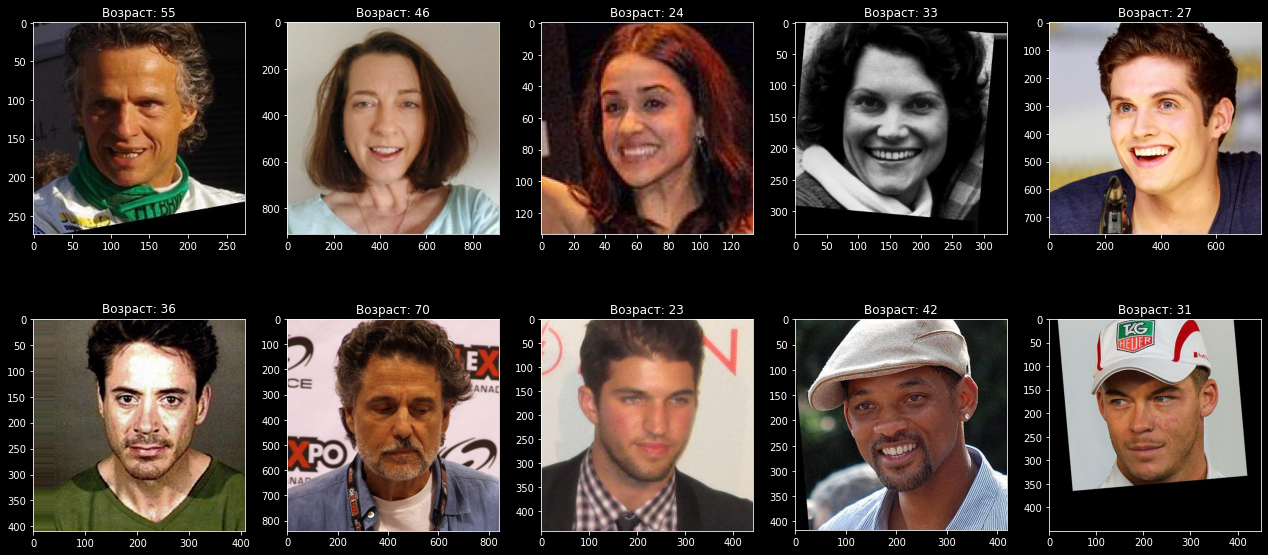

In [ ]:
_, axs = plt.subplots(2, 5, figsize=(22, 10))
k = 0
for j in range(2):
    for i in range(5):
        image = Image.open('/datasets/faces/final_files/' + 
                           labels.loc[rand_index[k]]['file_name'])
        image_array = np.array(image)
        axs[j, i].imshow(image_array)
        axs[j, i].set_title(f"Возраст: {labels.loc[rand_index[k]]['real_age']}")
        k += 1

plt.show()

Датасет содержит фотографии простых людей и знаменитостей. Среди выведенных есть Роберт Дауни Мл. и Уилл Смит.

В целом, возраст соответствует фотографиям, значительных ошибок не заметно.

Оригинальный датасет содержит два типа фотографий - "оригинальные" и обработанные, в которых выполнено кадрирование лица и разворот изображения таким образом, чтобы лицо располагалось горизонтально.
Судя по выведенным фотографиям, в настоящей задаче используются обработанные фотографии, в связи с чем при обучении модели их аугментация в виде поворотов и горизонтального отражения представлется нецелесообразной.

В ходе предобработки фотографии преобрели артефакты в виде черных областей, размытости и разного размера.
Однако указанные эффекты не должны оказать значимого эффекта на точность работы модели и будут учтены средствами библиотеки tensorflow.

## Распределение целевого признака

Оценим распределение целевого признака и построим соответствующую гистограмму.

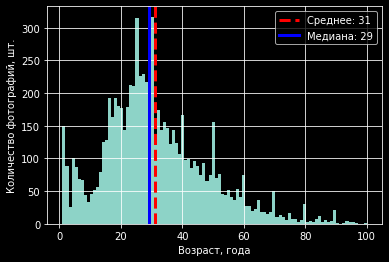

In [ ]:
labels['real_age'].hist(bins=100)
plt.xlabel('Возраст, года')
plt.ylabel('Количество фотографий, шт.')
plt.axvline(
    labels['real_age'].mean(),
    color='r',
    linewidth=3,
    linestyle="--", 
    label=f'Среднее: {round(labels["real_age"].mean())}'
)
plt.axvline(
    labels['real_age'].median(),
    color='b',
    linewidth=3,
    linestyle="-",
    label=f'Медиана: {round(labels["real_age"].median())}'
)
plt.legend()
plt.show()

Форма гистограммы cоответствует форме аналогичного рисунка, приведенного в статье, однако количественные значения на ней примерно в три раза больше, чем в публикации. 
Это может быть объяснено тем, что авторы использовали для построения гистограммы не весь датасет, а только его тестовую часть.

По грaфику видно, что медиана и среднее находятся очень близко друг к другу, что говорит о распределении данных без существенных выбросов.
Тем не менее, количество фотографий, отмеченных возрастом, кратным 5 заметно выбивается из общего тренда.

В датасете присутствует большое количество фотографий, отмеченных возрастом менее 10 и более 80. 
Проверим визуально, нет ли ошибки в разметке данных. 
Для этого создадим функцию вызова фотографии.

In [ ]:
def print_foto(file_name):
    image = Image.open('/datasets/faces/final_files/' + file_name)
    image_array = np.array(image)
    plt.imshow(image_array)
    plt.show()

Выберем случайную фотографию, отмеченную возрастом 1 год.

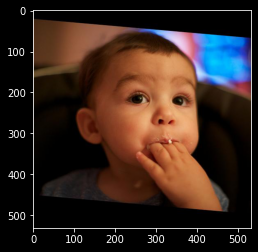

In [ ]:
np.random.seed(26)

one_yo_rand_index = labels[labels['real_age'] == 1].index[
    int(np.random.rand() * len(labels[labels['real_age'] == 1].index))]

print_foto(labels.loc[one_yo_rand_index]['file_name'])

Ребенок похож на годовалого (особенно по позе).

Выполним аналогичную операцию для фотографии, размеченной на столетнего человека.
Такая фотография в датасете только одна, поэтому код для ее вызова упрощается.

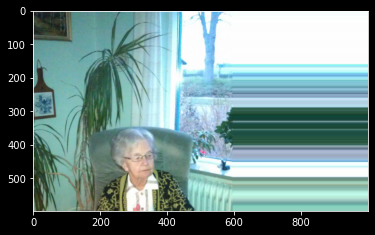

In [ ]:
print_foto(labels[labels['real_age'] == 100]['file_name'].values[0])

На этой фотографии произошло неудачное кадрирование лица и размазался фон.
При этом само лицо не увеличено.
Учитывая, что причины такого сбоя, а также их количество в датасете - неизвестны, дополнительно обрабатывать фотографию не будем. 

## Заключение по EDA

По проведенному анализу можно сделать следующие выводы.

* Данные размечены корректно, несоответствие возраста и фотографии не обнаружено.  
* Распределение возраста в датасете не содержит существенных выбросов и лежит в диапазоне от 1 до 100.  
* Для работы используются фотографиями с артефактами в виде черных областей, размытостей, сдвигов и другими. 

Кроме того, изображения обладают различным размером. 
Это обусловлено тем, что используется оригинальный датасет с кадрированием лица.
Такие артефакты не должны оказать значимого эффекта на точность предсказания нейронной сетью и будут учтены средствами библиотеки tensorflow.

# Моделирование

## Обучение модели

Обучим нейронную сеть на сервере с GPU.
Для этого созддим четыре функции:
1. загрузки обучающей выборки load_train(path),
1. загрузки тестовой выборки load_test(path),
1. создания модели create_model(input_shape),
1. запуска модели train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps).

*(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)*

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    # Загрузим данные
    labels = pd.read_csv(path + '/labels.csv')
    
    # Создадим загрузчик изображений с аугментацией и разделением 
    # на тестовую и валидационную выборки в пропорциях 3:1
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        width_shift_range=0.2, 
        rescale=1/255.
    )

    # Загрузим сами изображения для тестовой выборки, используя датафрейм labels
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(350, 350),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=26
    )

    return train_datagen_flow


def load_test(path):
    # Загрузим данные
    labels = pd.read_csv(path + '/labels.csv')
    
    # Создадим загрузчик изображений с разделением 
    # на тестовую и валидационную выборки в пропорциях 3:1 и без аугментации
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.
    )

    # Загрузим сами изображения для тестовой выборки, используя датафрейм labels
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(350, 350),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=26
    )

    return train_datagen_flow


def create_model(input_shape):
    # Загрузим в качестве хребта сеть ResNet с 50 слоями, которая обладает
    # производительностью, достаточной для решения поставленной задачи.
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    
    # Определим саму CNN. Целесообразно использовать метрику МАЕ, так как она используется в статье. 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    # Обучим модель
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-09-18 10:21:40.116945: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-18 10:21:41.050118: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 194s - loss: 273.1537 - mean_absolute_error: 11.7442 - val_loss: 922.8237 - val_mean_absolute_error: 25.5933
Epoch 2/20
178/178 - 189s - loss: 89.9848 - mean_absolute_error: 7.1754 - val_loss: 640.8920 - val_mean_absolute_error: 20.2960
Epoch 3/20
178/178 - 188s - loss: 63.9972 - mean_absolute_error: 6.1077 - val_loss: 349.5410 - val_mean_absolute_error: 14.0819
Epoch 4/20
178/178 - 192s - loss: 46.0192 - mean_absolute_error: 5.2113 - val_loss: 151.3636 - val_mean_absolute_error: 9.6692
Epoch 5/20
178/178 - 180s - loss: 35.2111 - mean_absolute_error: 4.5643 - val_loss: 99.6081 - val_mean_absolute_error: 7.7418
Epoch 6/20
178/178 - 182s - loss: 30.3480 - mean_absolute_error: 4.2414 - val_loss: 76.1205 - val_mean_absolute_error: 6.6066
Epoch 7/20
178/178 - 183s - loss: 26.1026 - mean_absolute_error: 3.9448 - val_loss: 62.4930 - val_mean_absolute_error: 5.9930
Epoch 8/20
178/178 - 186s - loss: 22.2630 - mean_absolute_error: 3.6246 - val_loss: 65.3426 - val_mean_absolute_error: 6.1853
Epoch 9/20
178/178 - 187s - loss: 18.6519 - mean_absolute_error: 3.3341 - val_loss: 62.5177 - val_mean_absolute_error: 5.8867
Epoch 10/20
178/178 - 194s - loss: 15.6194 - mean_absolute_error: 3.0664 - val_loss: 62.6420 - val_mean_absolute_error: 5.9111
Epoch 11/20
178/178 - 204s - loss: 14.7997 - mean_absolute_error: 2.9479 - val_loss: 67.9063 - val_mean_absolute_error: 6.1953
Epoch 12/20
178/178 - 197s - loss: 13.1794 - mean_absolute_error: 2.7804 - val_loss: 83.3675 - val_mean_absolute_error: 6.6813
Epoch 13/20
178/178 - 192s - loss: 11.6602 - mean_absolute_error: 2.6480 - val_loss: 67.8574 - val_mean_absolute_error: 6.2036
Epoch 14/20
178/178 - 194s - loss: 10.9600 - mean_absolute_error: 2.5295 - val_loss: 71.0277 - val_mean_absolute_error: 6.2977
Epoch 15/20
178/178 - 201s - loss: 10.0703 - mean_absolute_error: 2.4228 - val_loss: 63.2947 - val_mean_absolute_error: 5.9482
Epoch 16/20
178/178 - 202s - loss: 9.2248 - mean_absolute_error: 2.3177 - val_loss: 64.3997 - val_mean_absolute_error: 5.9587
Epoch 17/20
178/178 - 186s - loss: 9.5091 - mean_absolute_error: 2.3572 - val_loss: 59.1594 - val_mean_absolute_error: 5.7455
Epoch 18/20
178/178 - 204s - loss: 9.3475 - mean_absolute_error: 2.3315 - val_loss: 62.3544 - val_mean_absolute_error: 5.8701
Epoch 19/20
178/178 - 204s - loss: 8.3711 - mean_absolute_error: 2.1851 - val_loss: 61.2455 - val_mean_absolute_error: 5.9784
Epoch 20/20
178/178 - 193s - loss: 7.5490 - mean_absolute_error: 2.0760 - val_loss: 57.8941 - val_mean_absolute_error: 5.6493

60/60 - 15s - loss: 57.8941 - mean_absolute_error: 5.6493

Test MAE: 5.6493

```

## Анализ обученной модели

В качестве бэкбона модели использована предобученная сеть ResNet50 без последнего слоя.
Веса модели использованы из библиотеки keras и предварительно скачаны на сервер.
Финальный слой модели является полносвязанным и на выходе имеет одно число - возраст человека на фотографии.
Для активации слоя использована функция линейного выпрямителя (ReLU), отсекающая отрицательные значения.

Заморозка весов бэкбона приводит к уменьшению переобучаемости модели, однако требует большего количества эпох обучения для достижения того же значения метрики на тестовой выборке.
К ухудшению метрики приводит и уменьшение размера загруженного изображения (target_size), увеличение скорости обучения оптимизатора (learning_rate) и уменьшение количества эпох (epochs).

В результате обучения нейронной сети получено значение метрики МАЕ 6,3 года, что удовлетворяет заданному критерию - не более 8.
При этом, модель является переобученной, так как метрики обучающей и тестовой выборок отличаются примерно в два раза. 

Не смотря на более современный тип используемой в настоящей работе сети, значение метрики больше, полученного в статье примерно на 3%.
Достижение результата авторов статьи возможно за счет увеличения количества эпох тренировки модели или за счет применения техники bootstrap.

# Выводы

Проведен исследовательский анализ набора фотографий, в ходе которого определена корректность их разметки.
Распределение возраста в датасете лежит в диапазоне от 1 до 100, что позволяет определить возраст в этом же диапазоне.  

Подготовлены данные и проведено обучение нейронной сети. Ее качество, измеряемое при помощи метрики МАЕ составило 6,3 года, что удовлетворяет заданному критерию.

Разработанная модель пригодна для использования в системе обработки фотографий покупателей. 
Однако, учитывая специфику ее использования (определение возрастной группы для таргетированных предложений и контроль работы кассиров), представляется целесообразным уточнить техническое задание и разработать модель классификации возрастных групп.
Подобные модели обладают более высокой точностью предсказания и могут принести большую пользу бизнесу.